In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt

from filtering_gam import Model, Optimizer

In [2]:
warnings.simplefilter('ignore')

In [3]:
SEED = 42

In [4]:
def synthetic_signals_clf(n, seed=None):
    
    rng = np.random.default_rng(seed)
    
    X, y = [], []
    for _ in range(n):

        # indices
        idx0 = rng.integers(low=20, high=40)
        idx1 = idx0 + rng.integers(low=20, high=40)

        # shape, scale, severity
        shape = rng.integers(low=100, high=105)
        scale = rng.normal()**2
        severity = rng.uniform(low=0.01, high=0.5)

        # data
        data = rng.normal(size=shape) + 100
        data *= scale
        data[idx0:idx1] *= severity

        # labels
        labels = np.zeros(shape)
        labels[[idx0,idx1]] = 1.

        X.append(data)
        y.append(labels)
        
    return X, y


In [5]:
def synthetic_signals_reg(n, seed=None):
    
    rng = np.random.default_rng(seed)
    
    X, y = [], []
    for _ in range(n):

        # shape, scale, severity
        shape = rng.integers(low=90, high=110)
        scale = rng.normal()**2

        # data
        data = rng.normal(size=shape).cumsum()
        data -= data.min()
        data += scale
 
        X.append(data[:-1])
        y.append(data[1:])
        
    return X, y


In [6]:
def transform_reg_results(y_true, y_pred):
    
    y_pred = (y_pred-y_pred.mean()) / y_pred.std()
    y_pred = (y_pred*y_true.std()) + y_true.mean()
    
    return y_pred


---

$ \text{Pr}(y_i=1 | y) = \sigma\left( s_m(y)_i F^T \beta + \alpha \right) $  
_where_: <br>
&ensp; $y$ is a 1-dimmensional signal  
&ensp; $\sigma$ is the sigmoid function  
&ensp; $s_m$ is the segmentation function, subsequence lengths ($m$) equal filter lengths  
&ensp; $F$ is a matrix of filters, each row is an individual filter  
&ensp; $\beta$ is a vector of weight terms, number of terms equal number of filters $m$   
&ensp; $\alpha$ is the bias term  

$ s_3(y) = \begin{bmatrix} y_1 & y_2 & y_3 \\ y_2 & y_3 & y_4 \\ y_3 & y_4 & y_5 \\ ... & ... & ... \\ y_{n-2} & y_{n-1} & y_n \end{bmatrix} $ $ F = \begin{bmatrix} 1 & 0 & -1 \\ 1 & -1 & 1 \end{bmatrix} $  

Filter 1: $ (1, 0, -1) $  
Filter 2: $ (1, -1, 1) $  

---

### Changepoints

In [7]:
X_train, y_train = synthetic_signals_clf(20, SEED)

In [8]:
"""
weights0 = np.array([-2., 0.05, 0.05])
filters0 = np.vstack([
    np.linspace(1,-1,9),
    np.linspace(-1,1,9),
])
model = Model(weights=weights0, filters=filters0)
""";

In [9]:
model = Model(
    filters=(5,7), # 5 filters, each length of 5
    weights=-1, 
    av=True, 
    pr=True, 
    bn=False, 
    seed=SEED,
)

In [10]:
optimizer = Optimizer(
    model=model, 
    weight=True, 
    loss='entropy', 
    penalty=None, 
    epochs=50,
    gamma=0., 
    alpha=0.1, 
    eta0=0.001, 
    tol=0.001,
)

In [11]:
optimizer.train(X_train, y_train)

In [12]:
sample = X_train[0]
y_hat = model(sample, fill=np.nan)

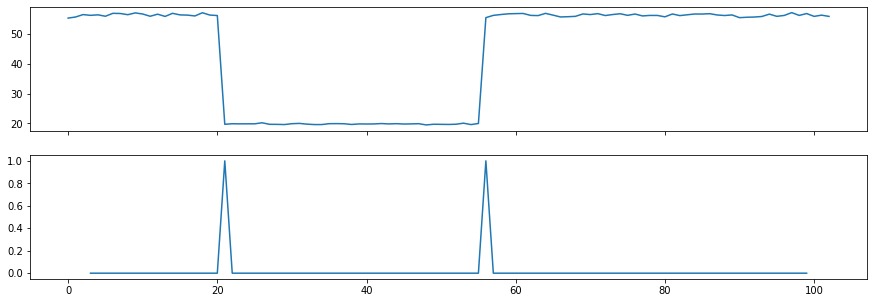

In [13]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,5))
ax1, ax2 = axes
ax1.plot(sample)
ax2.plot(y_hat)
ax2.set_ylim([-0.05, 1.05])
plt.show()

---

### Subsequences

In [ ]:
import custom_utils as cu

rng = np.random.default_rng(SEED)

X_train = cu.periodic_signal(100, 7)
X_train[40:60] = cu.periodic_signal(20, 3)
X_train = X_train*5 + rng.normal(size=100, scale=0.1)

y_train = np.zeros(100)
y_train[[40,60]] = 1

X_train, y_train = [X_train], [y_train]

In [ ]:
model = Model(
    filters=(5,7),
    weights=-1, 
    av=True, 
    pr=True, 
    bn=False, 
    seed=SEED,
)

In [ ]:
optimizer = Optimizer(
    model=model, 
    weight=True, 
    loss='entropy', 
    penalty=None, 
    epochs=500,
    gamma=0.0001, 
    alpha=0.1, 
    eta0=0.1, 
    tol=0.001,
)

In [ ]:
optimizer.train(X_train, y_train)

In [ ]:
sample = X_train[0]
y_hat = model(sample, fill=np.nan)

In [ ]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,5))
ax1, ax2 = axes
ax1.plot(sample)
ax2.plot(y_hat)
ax2.set_ylim([-0.05, 1.05])
plt.show()

---

### Spikes

In [ ]:
rng = np.random.default_rng(SEED)

anoms = rng.integers(low=0, high=100, size=3)
X_train = rng.normal(size=100, scale=0.5, loc=20)
X_train[anoms] *= rng.normal(size=3, scale=0.001, loc=0)

y_train = np.zeros(100)
y_train[anoms] = 1

X_train, y_train = [X_train], [y_train]

In [ ]:
model = Model(
    filters=(7,3),
    weights=-1, 
    av=True, 
    pr=True, 
    bn=True, 
    seed=SEED,
)

In [ ]:
optimizer = Optimizer(
    model=model, 
    weight=True, 
    loss='entropy', 
    penalty=None, 
    epochs=1000,
    gamma=0.00002, 
    alpha=0.1, 
    eta0=0.15, 
    tol=0.0001,
)

In [ ]:
optimizer.train(X_train, y_train)

In [ ]:
sample = X_train[0]
y_hat = model(sample, fill=np.nan)

In [ ]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,5))
ax1, ax2 = axes
ax1.plot(sample)
ax2.plot(y_hat)
ax2.set_ylim([-0.05, 1.05])
plt.show()

---

### Regression

In [ ]:
X_train, y_train = synthetic_signals_reg(10)

In [ ]:
model = Model(
    filters=(5,5), # 5 filters, each length of 5
    weights=-1, 
    av=False, 
    pr=False, 
    bn=True, 
    seed=SEED,
)

In [ ]:
optimizer = Optimizer(
    model=model, 
    weight=False, 
    loss='mse', 
    penalty=None, 
    epochs=50,
    gamma=0., 
    alpha=0.1, 
    eta0=0.001, 
    tol=0.001,
)

In [ ]:
optimizer.train(X_train, y_train)

In [ ]:
sample = X_train[0]
y_hat = model(sample, fill=None)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(sample, 'b-')
plt.plot(y_hat, 'r--')
plt.show()

---

In [ ]:
optimizer = Optimizer(
    model=model, 
    epochs=500,
    gamma=0.0001, 
    eta0=0.1, 
)

In [ ]:
eta = float(optimizer.eta0)
epochs = optimizer.epochs
trace = []
for step in range(epochs):
    trace.append(eta)
    eta = optimizer.eta_schedule(eta, step)
plt.plot(trace)